# 🧭 Projet - Problème du Voyageur de Commerce (TSP)

---

Ce projet explore des heuristiques pour résoudre le **Problème du Voyageur de Commerce (Travelling Salesman Problem)**.
Nous allons implémenter et comparer différentes approches pour trouver un circuit de coût minimal visitant chaque ville une seule fois.

---

👨‍💻 Myriam HADDOUK & Myriam SCHULMANN
🎓 Projet Mathématiques-informatique
📅 Juin 2025

**Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

### **City Generation**

In [ ]:
def generate_cities(n: int, seed: int = None) -> np.ndarray:
    """
    Generate a set of cities with random (x, y) coordinates in a 1000x1000 grid.

    Parameters:
    - n (int): Number of cities to generate.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - np.ndarray: Array of shape (n, 2) with x and y coordinates of each city.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    return np.random.randint(0, 1000, size=(n, 2))

In [ ]:
cities = generate_cities(20, seed=42)
print(cities)

**Distance Matrix**

In [ ]:
def compute_distance_matrix(cities: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise Euclidean distance matrix between all cities.

    Parameters:
    - cities (np.ndarray): Array of shape (n, 2) with x and y coordinates.

    Returns:
    - np.ndarray: Array of shape (n, n) with distances between each pair of cities.
    """
    n = cities.shape[0]
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                dx = cities[i][0] - cities[j][0]
                dy = cities[i][1] - cities[j][1]
                matrix[i][j] = math.hypot(dx, dy)

    return matrix

In [ ]:
distance_matrix = compute_distance_matrix(cities)
print(distance_matrix)

### **Heuristics**

**Nearest Neighbor**

In [ ]:
def nearest_neighbor_tour(distance_matrix: np.ndarray, start: int = 0) -> list:
    """
    Construct a TSP tour using the nearest neighbor heuristic.

    Parameters:
    - distance_matrix (np.ndarray): Pairwise distance matrix.
    - start (int): Index of the starting city.

    Returns:
    - list: Ordered list of city indices representing the tour.
    """
    n = distance_matrix.shape[0]
    visited = [False] * n
    tour = [start]
    visited[start] = True

    current = start
    for _ in range(n - 1):
        next_city = min(
            (i for i in range(n) if not visited[i]),
            key=lambda i: distance_matrix[current][i]
        )
        tour.append(next_city)
        visited[next_city] = True
        current = next_city

    return tour

In [ ]:
tour = nearest_neighbor_tour(distance_matrix, start=0)
print(tour)

**Insertion**

In [ ]:
def insertion_tour(distance_matrix: np.ndarray, start: int = 0) -> list:
    """
    Build a TSP tour using the insertion heuristic (e.g. cheapest insertion).

    Parameters:
    - distance_matrix (np.ndarray): Pairwise distance matrix.
    - start (int): Index of the starting city.

    Returns:
    - list: Ordered list of city indices representing the tour.
    """
    n = distance_matrix.shape[0]
    unvisited = set(range(n))
    tour = [start]
    unvisited.remove(start)

    nearest = min(unvisited, key=lambda i: distance_matrix[start][i])
    tour.append(nearest)
    unvisited.remove(nearest)

    tour.append(start)

    while unvisited:
        best_city = None
        best_position = None
        min_increase = float('inf')

        for city in unvisited:
            for i in range(1, len(tour)):
                prev_city = tour[i - 1]
                next_city = tour[i]
                increase = (
                    distance_matrix[prev_city][city] +
                    distance_matrix[city][next_city] -
                    distance_matrix[prev_city][next_city]
                )
                if increase < min_increase:
                    min_increase = increase
                    best_city = city
                    best_position = i

        tour.insert(best_position, best_city)
        unvisited.remove(best_city)

    return tour[:-1]

In [ ]:
tour = insertion_tour(distance_matrix, start=0)
print(tour)

**Two-Opt**

In [ ]:
def two_opt(tour: list, distance_matrix: np.ndarray) -> list:
    """
    Improve a given TSP tour using the two-opt heuristic.

    Parameters:
    - tour (list): Initial tour as a list of city indices.
    - distance_matrix (np.ndarray): Pairwise distance matrix.

    Returns:
    - list: Locally optimized tour using two-opt.
    """
    improved = True
    n = len(tour)
    best = tour[:]

    def tour_length(t):
        return sum(distance_matrix[t[i]][t[(i + 1) % n]] for i in range(n))

    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                if j - i == 1:
                    continue
                new_tour = best[:i] + best[i:j][::-1] + best[j:]
                if tour_length(new_tour) < tour_length(best):
                    best = new_tour
                    improved = True
                    break
            if improved:
                break

    return best

In [ ]:
initial_tour = nearest_neighbor_tour(distance_matrix, start=0)
print(initial_tour)
optimized_tour = two_opt(initial_tour, distance_matrix)
print(optimized_tour)

In [ ]:
initial_tour = insertion_tour(distance_matrix, start=0)
print(initial_tour)
optimized_tour = two_opt(initial_tour, distance_matrix)
print(optimized_tour)

**Simulated Annealing**

In [49]:
def simulated_annealing(
    initial_tour: list,
    distance_matrix: np.ndarray,
    initial_temp: float = 1000,
    final_temp: float = 1,
    alpha: float = 0.995,
    max_iter: int = 10000
) -> list:
    """
    Apply simulated annealing to improve a TSP tour.

    Parameters:
    - initial_tour (list): Starting tour (e.g. from nearest neighbor).
    - distance_matrix (np.ndarray): Pairwise distance matrix.
    - initial_temp (float): Initial temperature.
    - final_temp (float): Final temperature to stop.
    - alpha (float): Cooling rate.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - list: Final optimized tour.
    """
    def tour_cost(tour):
        return sum(distance_matrix[tour[i]][tour[(i + 1) % len(tour)]] for i in range(len(tour)))

    def swap_two(tour):
        i, j = sorted(random.sample(range(len(tour)), 2))
        return tour[:i] + tour[i:j+1][::-1] + tour[j+1:]

    current = initial_tour[:]
    current_cost = tour_cost(current)
    best = current[:]
    best_cost = current_cost
    temp = initial_temp

    for _ in range(max_iter):
        if temp <= final_temp:
            break

        candidate = swap_two(current)
        candidate_cost = tour_cost(candidate)
        delta = candidate_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / temp):
            current = candidate
            current_cost = candidate_cost
            if candidate_cost < best_cost:
                best = candidate
                best_cost = candidate_cost

        temp *= alpha

    return best

In [56]:
start_tour = nearest_neighbor_tour(distance_matrix, start=0)
print(start_tour)
final_tour = simulated_annealing(start_tour, distance_matrix)
print(final_tour)

[0, 7, 17, 2, 15, 5, 16, 12, 19, 10, 11, 13, 1, 9, 4, 3, 6, 8, 14, 18]
[1, 13, 19, 18, 14, 8, 6, 12, 16, 0, 7, 17, 2, 15, 5, 4, 3, 9, 10, 11]


In [58]:
start_tour = insertion_tour(distance_matrix, start=0)
print(start_tour)
final_tour = simulated_annealing(start_tour, distance_matrix)
print(final_tour)

[0, 6, 19, 12, 8, 14, 18, 13, 1, 11, 10, 9, 3, 4, 16, 5, 15, 2, 17, 7]
[4, 9, 3, 1, 13, 11, 10, 19, 18, 14, 8, 0, 7, 17, 2, 15, 6, 12, 16, 5]


### **Visualization**

**Single Tour**

In [124]:
def plot_tour(
    cities: np.ndarray,
    tour: list,
    title: str = "TSP Tour",
    show_lengths: bool = False
):
    """
    Display a single TSP tour with optional edge lengths.

    Parameters:
    - cities (np.ndarray): City coordinates.
    - tour (list): Ordered list of city indices forming the tour.
    - title (str): Plot title.
    - show_lengths (bool): If True, display segment distances on the plot.
    """
    x = [cities[i][0] for i in tour] + [cities[tour[0]][0]]
    y = [cities[i][1] for i in tour] + [cities[tour[0]][1]]

    plt.figure(figsize=(8, 6))
    plt.plot(x, y, marker='o')
    plt.scatter(cities[:, 0], cities[:, 1], s=200, color='red', zorder=4)

    for idx, (xi, yi) in enumerate(cities):
        plt.text(xi, yi, str(idx), fontsize=8, weight='bold', ha='center', va='center', color='black', zorder=5)

    if show_lengths:
        for i in range(len(tour)):
            a, b = tour[i], tour[(i + 1) % len(tour)]
            xa, ya = cities[a]
            xb, yb = cities[b]
            mid_x, mid_y = (xa + xb) / 2, (ya + yb) / 2
            dist = math.hypot(xa - xb, ya - yb)
            plt.text(
                mid_x, mid_y, f"{dist:.1f}", fontsize=7, color='black',
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
            )

    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.show()

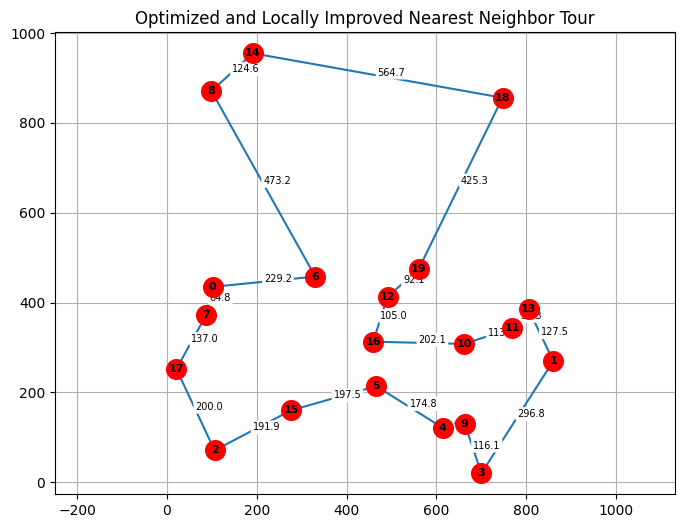

In [125]:
tour = two_opt(simulated_annealing(nearest_neighbor_tour(distance_matrix, start=0), distance_matrix), distance_matrix)
plot_tour(cities, tour, title="Optimized and Locally Improved Nearest Neighbor Tour", show_lengths=True)

**Multiple Tours**

In [128]:
def plot_multiple_tours(
    cities: np.ndarray,
    tours: list,
    labels: list = None,
    title: str = "Multiple TSP Tours"
):
    """
    Display multiple TSP tours on the same city map for comparison.

    Parameters:
    - cities (np.ndarray): City coordinates.
    - tours (list of list): List of tours to plot.
    - labels (list of str): Optional labels for the legend.
    - title (str): Plot title.
    """
    if len(tours) > 3:
        print("⚠️ Warning: plotting more than 3 tours may reduce readability.")

    plt.figure(figsize=(8, 6))

    colors = [
        'blue', 'orange', 'green', 'purple', 'brown',
        'pink', 'gray', 'olive', 'cyan', 'red'
    ]
    linestyles = ['-', '--', ':', '-.']

    for idx, tour in enumerate(tours):
        x = [cities[i][0] for i in tour] + [cities[tour[0]][0]]
        y = [cities[i][1] for i in tour] + [cities[tour[0]][1]]
        color = colors[idx % len(colors)]
        style = linestyles[idx % len(linestyles)]
        label = labels[idx] if labels and idx < len(labels) else f"Tour {idx+1}"
        plt.plot(x, y, linestyle=style, color=color, marker='o', label=label)

    plt.scatter(cities[:, 0], cities[:, 1], color='black', zorder=5)
    for idx, (xi, yi) in enumerate(cities):
        plt.text(xi + 5, yi + 5, str(idx), fontsize=8)

    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

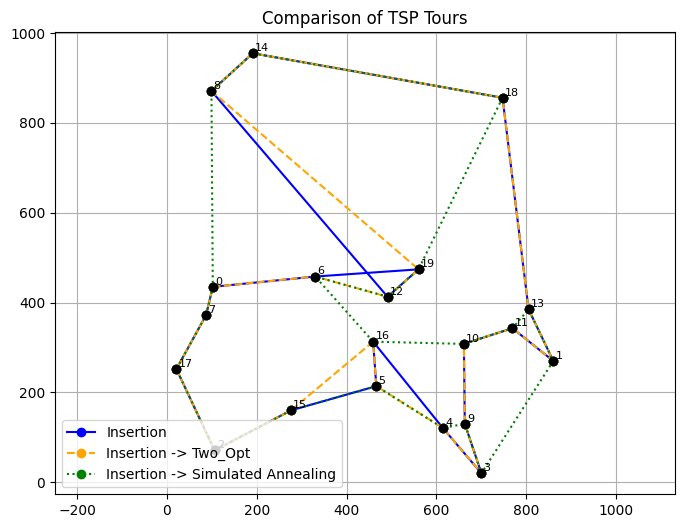

In [130]:
tour = insertion_tour(distance_matrix)
tours = [
    tour,
    two_opt(tour, distance_matrix),
    simulated_annealing(tour, distance_matrix)
]

plot_multiple_tours(
    cities,
    tours,
    labels=["Insertion", "Insertion -> Two_Opt", "Insertion -> Simulated Annealing"],
    title="Comparison of TSP Tours"
)